In [101]:
from lsst import afw
print(afw.version.__version__)
from lsst.daf.persistence import Butler
from lsst.eotest.sensor import MaskedCCD, makeAmplifierGeometry
import numpy

from exploreRun import exploreRun
from lsst.eo_utils.base.image_utils import get_ccd_from_id,\
    get_amp_list, get_data_as_read, sort_sflats

from lsst.eo_utils.base.data_access import get_data_for_run

import lsst.eotest.image_utils as imutil
import pylab
%matplotlib inline


19.0.0


In [102]:
fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_red_-211.815_-0.395.fits"
ccob = get_ccd_from_id(None, fname, [])

In [103]:
fname = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superflat/RTM-013/RTM-013-10982-S21_superflat_normal_h.fits"
ts8flat = get_ccd_from_id(None, fname, [])

Let's take a ratio. There is a document for available operators.
http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/classlsst_1_1afw_1_1image_1_1_masked_image.html#aa455aea279302ba14f7ea80470d1c962

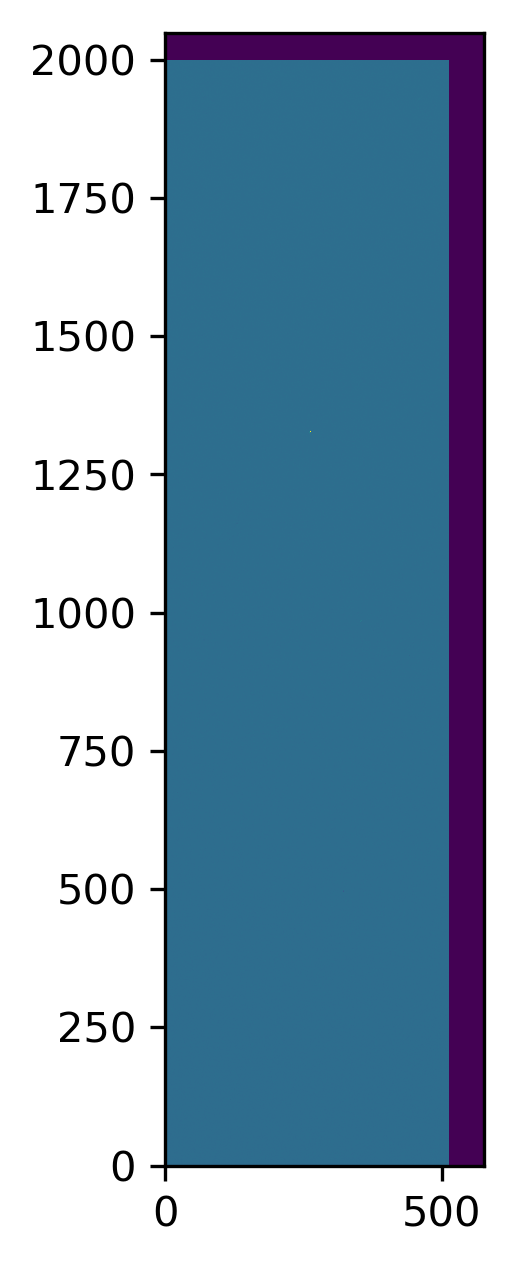

In [104]:
ratio=get_data_as_read(ccob,1,["imaging"])["imaging"] / get_data_as_read(ts8flat,1,["imaging"])["imaging"]
fig, axs = pylab.subplots(1,1,figsize=(5,5),dpi=300) 
axs.imshow(tmp.image.array,origin="lower")

In [105]:
tmp

lsst.afw.image.maskedImage.maskedImage.MaskedImageF=(image=[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]],
mask=[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], maskPlaneDict={'BAD': 0, 'CR': 3, 'DETECTED': 5, 'DETECTED_NEGATIVE': 6, 'EDGE': 4, 'INTRP': 2, 'NO_DATA': 8, 'SAT': 1, 'SUSPECT': 7}
variance=[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], bbox=(minimum=(0, 0), maximum=(575, 2047)))

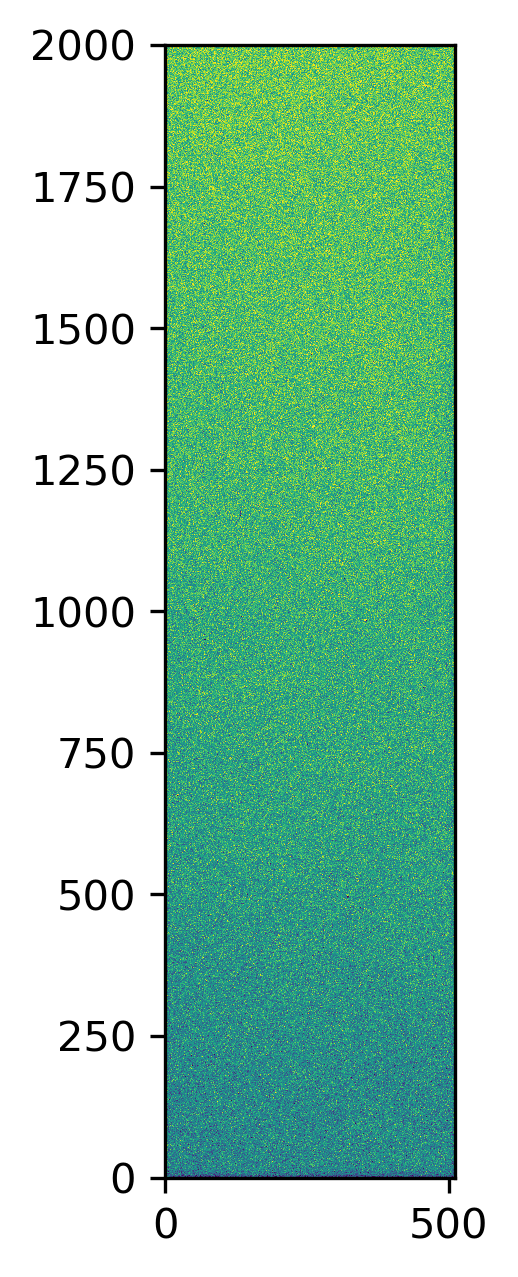

In [113]:
from astropy.stats import mad_std
subsec = tmp.image.array[:2000,:512]
std = mad_std(subsec)
mean = subsec.mean()
N = 3
fig, axs = pylab.subplots(1,1,figsize=(5,5),dpi=300) 
axs.imshow(subsec,origin="lower",vmin=mean-N*std,vmax=mean+N*std)